# TD Deep Q-Network

# Tutorial - Deep Q-Learning 

Deep Q-Learning uses a neural network to approximate $Q$ functions. Hence, we usually refer to this algorithm as DQN (for *deep Q network*).

The parameters of the neural network are denoted by $\theta$. 
*   As input, the network takes a state $s$,
*   As output, the network returns $Q_\theta [a | s] = Q_\theta (s,a) = Q(s, a, \theta)$, the value of each action $a$ in state $s$, according to the parameters $\theta$.


The goal of Deep Q-Learning is to learn the parameters $\theta$ so that $Q(s, a, \theta)$ approximates well the optimal $Q$-function $Q^*(s, a) \simeq Q_{\theta^*} (s,a)$. 

In addition to the network with parameters $\theta$, the algorithm keeps another network with the same architecture and parameters $\theta^-$, called **target network**.

The algorithm works as follows:

1.   At each time $t$, the agent is in state $s_t$ and has observed the transitions $(s_i, a_i, r_i, s_i')_{i=1}^{t-1}$, which are stored in a **replay buffer**.

2.  Choose action $a_t = \arg\max_a Q_\theta(s_t, a)$ with probability $1-\varepsilon_t$, and $a_t$=random action with probability $\varepsilon_t$. 

3. Take action $a_t$, observe reward $r_t$ and next state $s_t'$.

4. Add transition $(s_t, a_t, r_t, s_t')$ to the **replay buffer**.

4.  Sample a minibatch $\mathcal{B}$ containing $B$ transitions from the replay buffer. Using this minibatch, we define the loss:

$$
L(\theta) = \sum_{(s_i, a_i, r_i, s_i') \in \mathcal{B}}
\left[
Q(s_i, a_i, \theta) -  y_i
\right]^2
$$
where the $y_i$ are the **targets** computed with the **target network** $\theta^-$:

$$
y_i = r_i + \gamma \max_{a'} Q(s_i', a', \theta^-).
$$

5. Update the parameters $\theta$ to minimize the loss, e.g., with gradient descent (**keeping $\theta^-$ fixed**): 
$$
\theta \gets \theta - \eta \nabla_\theta L(\theta)
$$
where $\eta$ is the optimization learning rate. 

6. Every $N$ transitions ($t\mod N$ = 0), update target parameters: $\theta^- \gets \theta$.

7. $t \gets t+1$. Stop if $t = T$, otherwise go to step 2.

In [1]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gym
from gym.wrappers import Monitor
import math
import time
import matplotlib.pyplot as plt

# from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import base64

In [2]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")
print(f"gym.__version__ = {gym.__version__}")

python --version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
torch.__version__ = 1.10.2
np.__version__ = 1.21.5
gym.__version__ = 0.21.0


## Torch 101

>"The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. 
[...] provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions." 
[PyTorch](https://pytorch.org/docs/stable/index.html)


### Variable types

In [3]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print('zero_torch is of type {:s}'.format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print('\nFloat:\n', zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print('Int:\n', zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print('Bool:\n', zero_torch_bool)

# Reshape
print('\nView new shape...', zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print('\nAlgebraic operations are overloaded:\n', a, '\n+\n', b, '\n=\n', a+b )

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[ 0.2478, -0.3654],
        [ 1.2189,  2.0457],
        [ 1.9736,  0.7346]]) 
+
 tensor([[-0.7527,  0.6741],
        [ 0.7389,  0.0289],
        [ 0.0501,  0.2717]]) 
=
 tensor([[-0.5050,  0.3087],
        [ 1.9578,  2.0746],
        [ 2.0237,  1.0062]])


### Gradient management

In [4]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to 
# handle automatic differentiation (i.e keeping track of the gradient and which 
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training 
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it. 
# However when returning the result of training, do use detach() to save memory 
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=0.1)

# Loss function
print('Initial guess:', theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()
    
    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2
    
    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()
    
    # Run one step of optimisation routine.
    optimizer.step()
    
print('Final estimate:', theta.detach())
print('The final estimate should be close to', y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([1.7991])
Final estimate: tensor([2.0008])
The final estimate should be close to tensor([2.])


## Setting the environment

### 1 - Define the GLOBAL parameters

In [5]:
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 20 #32

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 200

# Learning rate
LEARNING_RATE = 0.1

### 2 - Replay buffer

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

### 3 - Neural Network

In [7]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

### 3.5 - Loss function and optimizer

In [8]:
# create network and target network
hidden_size = 128
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

q_net = Net(obs_size, hidden_size, n_actions)
target_net = Net(obs_size, hidden_size, n_actions)
#target_net.eval()

# objective and optimizer
objective = nn.MSELoss()
optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)

### Question 0 (to do at home, not during the live session)

With your own word, explain the intuition behind DQN. Recall the main parts of the aformentionned algorithm.

Value Iteration, Policy evaluation or Q-Learning methods are efficient on a small space-action environment or with discrete values. But when we increase the number of spaces and actions, for instance in a video game where each pixel represents a state and each states can take different actions, those methods aren't efficient anymore (for instance the size of the q-learning lookup table is way too big and the algo takes a long time to converge).
Deep Q-Learning uses Neural Networks to approximate the optimal q function.
A network (policy network) takes a state s as input and as output gives the q values for each action that could be taken at state s.
Another network (target network) is used to get the expected best q-value (gets asinput the state s' from the policy network andhas as output the q values from the actions that can be taken at sate s', we then take the max)



## Implementing the DQN

In [9]:
def get_q(states):
    """
    Compute Q function for a list of states
    """
    with torch.no_grad():
        states_v = torch.FloatTensor([states])
        output = q_net.forward(states_v).detach().numpy()  # shape (1, len(states), n_actions)
    return output[0, :, :]  # shape (len(states), n_actions)

#### Question 1

Implement the `choose_action` function.

In [10]:
def choose_action(state, epsilon):
    """
    ** TO BE IMPLEMENTED **
    
    Return action according to an epsilon-greedy exploration policy
    """
    r = random.random()
    if r < epsilon : #exploration
        return random.randrange(n_actions,step=1)
    else :  #exploitation
        with torch.no_grad():
            s = torch.tensor(state)
            return torch.argmax(q_net(s)).item()


#### Question 2

Implement the `eval_dqn` function.

In [11]:
def eval_dqn(n_sim=5):
    """
    ** TO BE IMPLEMENTED **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state = env_copy.reset()
        r = 0
        while True :
            action = choose_action(state, EPSILON_MIN)
            next_state, reward, done, info = env_copy.step(action) 
            state = next_state
            r += reward
            if done :
                break
        episode_rewards[i] = r
    return episode_rewards

#### Question 3

Implement the `update` function

In [12]:
def update(state, action, reward, next_state, done):
    """
    ** TO BE COMPLETED **
    """
    
    # add data to replay buffer
    if done:
        next_state = None
    replay_buffer.push(state, action, reward, next_state)
    
    if len(replay_buffer) < BATCH_SIZE:
        return np.inf
    
    # get batch
    transitions = replay_buffer.sample(BATCH_SIZE)
    # Compute loss - TO BE IMPLEMENTED!
    states, actions, rewards, next_states = [], [], [], []
    mask = []
    for exp in transitions:
            states.append(exp[0])
            actions.append(exp[1])
            rewards.append(exp[2])
            if exp[3] is not None :
                next_states.append(exp[3])
                mask.append(True)
            else:
                mask.append(False)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor( actions, dtype=torch.long).view(-1,1)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.bool)
    
    values  = torch.zeros(BATCH_SIZE)   # to be computed using batch
    values = q_net(states).gather(1,actions)

    targets_ = torch.zeros(BATCH_SIZE)   # to be computed using batch
    targets_[mask] = target_net(next_states).max(1)[0].detach()
    
    targets = rewards + GAMMA*targets_
    
    loss = objective(values, targets.unsqueeze(1))



    # Optimize the model - UNCOMMENT!
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.detach().numpy()

#### Question 4
Train a DQN on the `env` environment.
*Hint* The mean reward after training should be close to 200.

In [13]:
EVAL_EVERY = 5
REWARD_THRESHOLD = 199

def train():
    state = env.reset()
    epsilon = EPSILON_START
    ep = 0
    total_time = 0
    while ep < N_EPISODES:
        action = choose_action(state, epsilon)

        # take action and update replay buffer and networks
        next_state, reward, done, _ = env.step(action)
        loss = update(state, action, reward, next_state, done)

        # update state
        state = next_state

        # end episode if done
        if done:
            state = env.reset()
            ep   += 1
            if ( (ep+1)% EVAL_EVERY == 0):
                rewards = eval_dqn()
                print("episode =", ep+1, ", reward = ", np.mean(rewards))
                if np.mean(rewards) >= REWARD_THRESHOLD:
                    break

            # update target network
            if ep % UPDATE_TARGET_EVERY == 0:
                target_net.load_state_dict(q_net.state_dict())
            # decrease epsilon
            epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN) * \
                            np.exp(-1. * ep / DECREASE_EPSILON )    

        total_time += 1

# Run the training loop
train()

# Evaluate the final policy
rewards = eval_dqn(20)
print("")
print("mean reward after training = ", np.mean(rewards))

episode = 5 , reward =  10.6
episode = 10 , reward =  10.6


C:\Users\magal\AppData\Local\Temp\ipykernel_5652\961606803.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  states = torch.tensor(states, dtype=torch.float32)


episode = 15 , reward =  9.6
episode = 20 , reward =  9.8
episode = 25 , reward =  9.6
episode = 30 , reward =  9.8
episode = 35 , reward =  10.8
episode = 40 , reward =  10.0
episode = 45 , reward =  12.0
episode = 50 , reward =  10.6
episode = 55 , reward =  10.2
episode = 60 , reward =  9.0
episode = 65 , reward =  21.2
episode = 70 , reward =  15.6
episode = 75 , reward =  10.8
episode = 80 , reward =  19.2
episode = 85 , reward =  17.2
episode = 90 , reward =  17.4
episode = 95 , reward =  21.4
episode = 100 , reward =  22.0
episode = 105 , reward =  18.0
episode = 110 , reward =  21.2
episode = 115 , reward =  24.6
episode = 120 , reward =  16.2
episode = 125 , reward =  45.2
episode = 130 , reward =  22.6
episode = 135 , reward =  64.4
episode = 140 , reward =  27.2
episode = 145 , reward =  136.0
episode = 150 , reward =  145.0
episode = 155 , reward =  114.0
episode = 160 , reward =  189.8
episode = 165 , reward =  149.4
episode = 170 , reward =  200.0

mean reward after train

#### Question 5

Experiment the policy network.

(Showing a video with a jupyter notebook, you may try this cell with Chrome/Chromium instead of Firefox. Otherwise, you may skip this question.)

In [14]:
def show_video():
    html = []
    for mp4 in Path("videos").glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
  
env = Monitor(env, './videos', force=True, video_callable=lambda episode: True)

for episode in range(1):
    done = False
    state = env.reset()
    while not done:
        action = choose_action(state, 0.0)
        state, reward, done, info = env.step(action)
env.close()

show_video()

C:\Users\magal\Anaconda3\envs\rl\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Impossible de modifier le mode thread une fois qu’il a été fixé
  warnings.warn(str(err))


### Experiments: Do It Yourself

Remember the set of global parameters:
```
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 32 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 200

# Learning rate
LEARNING_RATE = 0.1
```

#### Question 6

Craft an experiment and study the influence of the `BUFFER_CAPACITY` on the learning process (speed of *convergence*, training curves...) 

In [79]:

def get_train_info():
    state = env.reset()
    epsilon = EPSILON_START
    ep = 0
    total_time = 0
    rewards_training = []
    while ep < N_EPISODES:
        action = choose_action(state, epsilon)

        # take action and update replay buffer and networks
        next_state, reward, done, _ = env.step(action)
        loss = update(state, action, reward, next_state, done)

        # update state
        state = next_state

        # end episode if done
        if done:
            state = env.reset()
            ep   += 1
            if ( (ep+1)% EVAL_EVERY == 0):
                rewards = eval_dqn(20)
                rewards_training.append(np.mean(rewards))
                if np.mean(rewards) >= REWARD_THRESHOLD:
                    break

            # update target network
            if ep % UPDATE_TARGET_EVERY == 0:
                target_net.load_state_dict(q_net.state_dict())
            # decrease epsilon
            epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN) * \
                            np.exp(-1. * ep / DECREASE_EPSILON )    

        total_time += 1
    return(rewards_training)

In [82]:
EVAL_EVERY = 1
UPDATE_TARGET_EVERY = 20
buffer_capacities = [500, 1000, 4000, 8000, 16000, 32000]
training_durations = []
rewards_per_buffer_capacity = []
for i in range(len(buffer_capacities)):
    # create network and target network
    BUFFER_CAPACITY = buffer_capacities[i]
    replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
    q_net = Net(obs_size, hidden_size, n_actions)
    target_net = Net(obs_size, hidden_size, n_actions)

    # objective and optimizer
    objective = nn.MSELoss()
    optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)
    # Run the training loop
    start = time.time()
    rewards = get_train_info()
    end = time.time()
    training_durations.append(end-start)
    rewards_per_buffer_capacity.append(rewards)
    print("end of training with buffer capacity : ", buffer_capacities[i])


end of training with buffer capacity :  500
end of training with buffer capacity :  1000
end of training with buffer capacity :  4000
end of training with buffer capacity :  8000
end of training with buffer capacity :  16000
end of training with buffer capacity :  32000


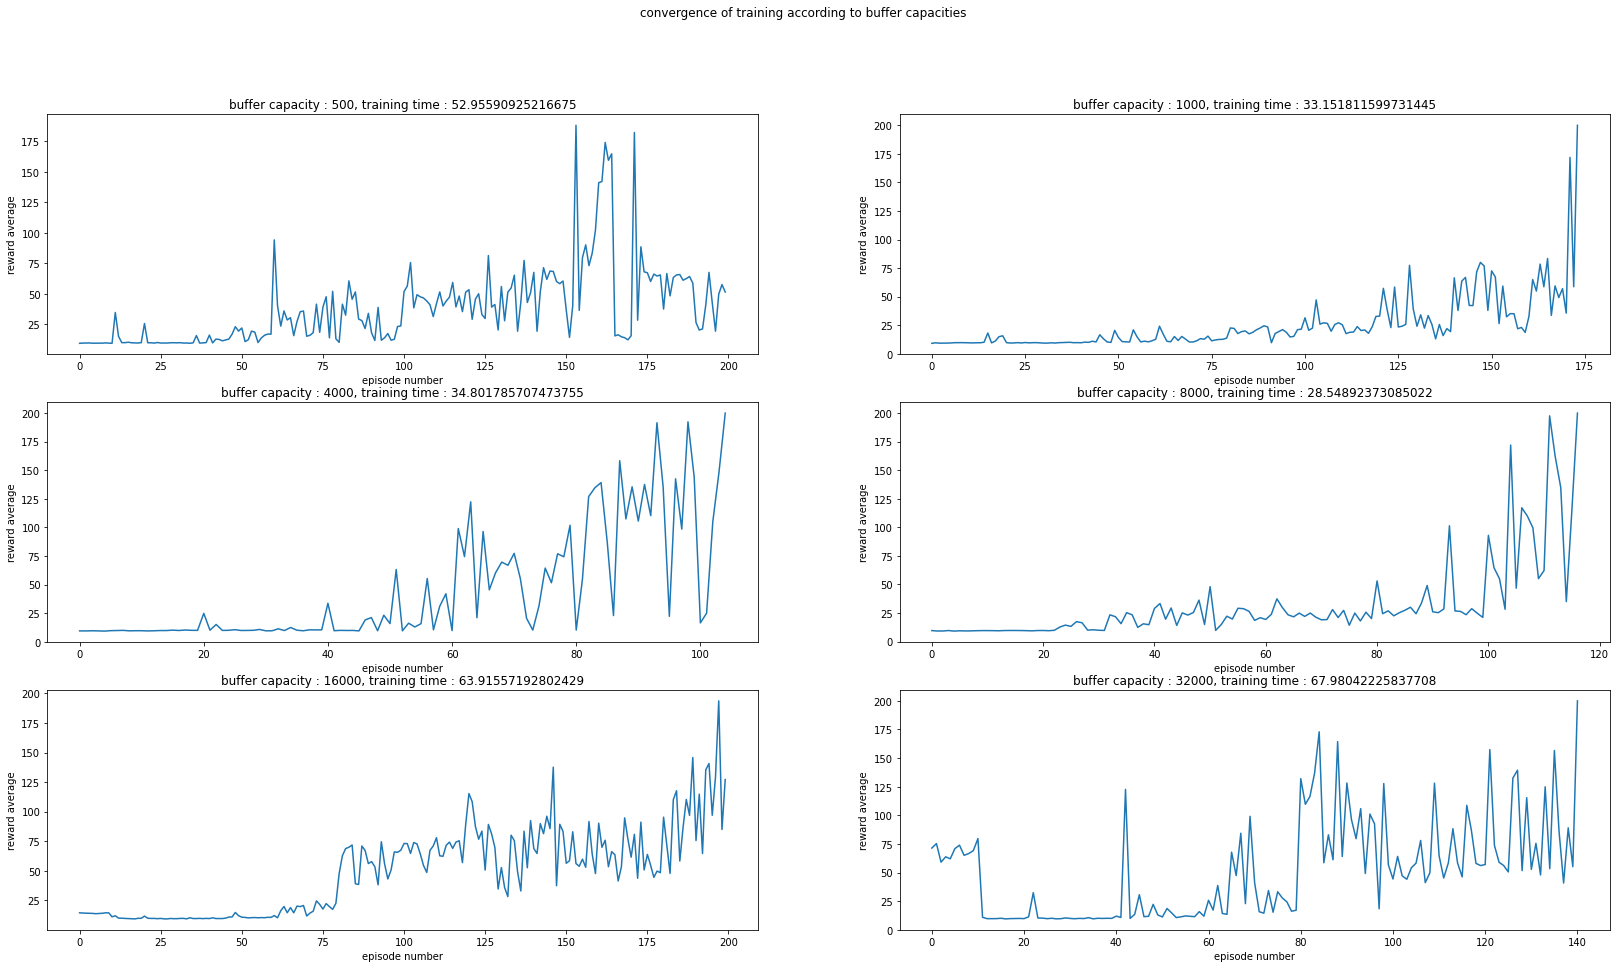

In [83]:

fig, axs = plt.subplots(3, 2, figsize=(28,15))
x=[[j for j in range(len(rewards_per_buffer_capacity[i])) ] for i in range(len(rewards_per_buffer_capacity))]
fig.suptitle('convergence of training according to buffer capacities')
axs[0, 0].plot(x[0], rewards_per_buffer_capacity[0])
axs[0, 0].set_title("buffer capacity : "+str(buffer_capacities[0])+", training time : "+str(training_durations[0]))

axs[0, 1].plot(x[1], rewards_per_buffer_capacity[1])
axs[0, 1].set_title("buffer capacity : "+str(buffer_capacities[1])+", training time : "+str(training_durations[1]))

axs[1, 0].plot(x[2], rewards_per_buffer_capacity[2])
axs[1, 0].set_title("buffer capacity : "+str(buffer_capacities[2])+", training time : "+str(training_durations[2]))

axs[1, 1].plot(x[3], rewards_per_buffer_capacity[3])
axs[1, 1].set_title("buffer capacity : "+str(buffer_capacities[3])+", training time : "+str(training_durations[3]))

axs[2, 0].plot(x[4], rewards_per_buffer_capacity[4])
axs[2, 0].set_title("buffer capacity : "+str(buffer_capacities[4])+", training time : "+str(training_durations[4]))

axs[2, 1].plot(x[5], rewards_per_buffer_capacity[5])
axs[2, 1].set_title("buffer capacity : "+str(buffer_capacities[5])+", training time : "+str(training_durations[5]))

for ax in axs.flat:
    ax.set(xlabel='episode number', ylabel='reward average')




**Graph anamysis buffer capacity**    
*With a low buffer capacity, the training convergence is stable with a reward close to 50.*    
*When the buffer capacity reaches 16000 it gets stable at a higher reward.*    
*The bigger the buffer capacity gets, the higher reward convergence points it gets.*   

#### Question 7

Craft an experiment and study the influence of the `UPDATE_TARGET_EVERY` on the learning process (speed of *convergence*, training curves...) 

In [84]:
BUFFER_CAPACITY = 16384
replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
target_every_values = [1, 5, 10, 20, 30, 40]
training_durations_target = []
rewards_per_target_value = []
for i in range(len(target_every_values)):
    # create network and target network
    
    UPDATE_TARGET_EVERY = target_every_values[i]
    q_net = Net(obs_size, hidden_size, n_actions)
    target_net = Net(obs_size, hidden_size, n_actions)

    # objective and optimizer
    objective = nn.MSELoss()
    optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)
    # Run the training loop
    start = time.time()
    rewards = get_train_info()
    end = time.time()
    training_durations_target.append(end-start)
    rewards_per_target_value.append(rewards)
    print("end of training with update_target_value : ", target_every_values[i])


end of training with update_target_value :  1
end of training with update_target_value :  5
end of training with update_target_value :  10
end of training with update_target_value :  20
end of training with update_target_value :  30
end of training with update_target_value :  40


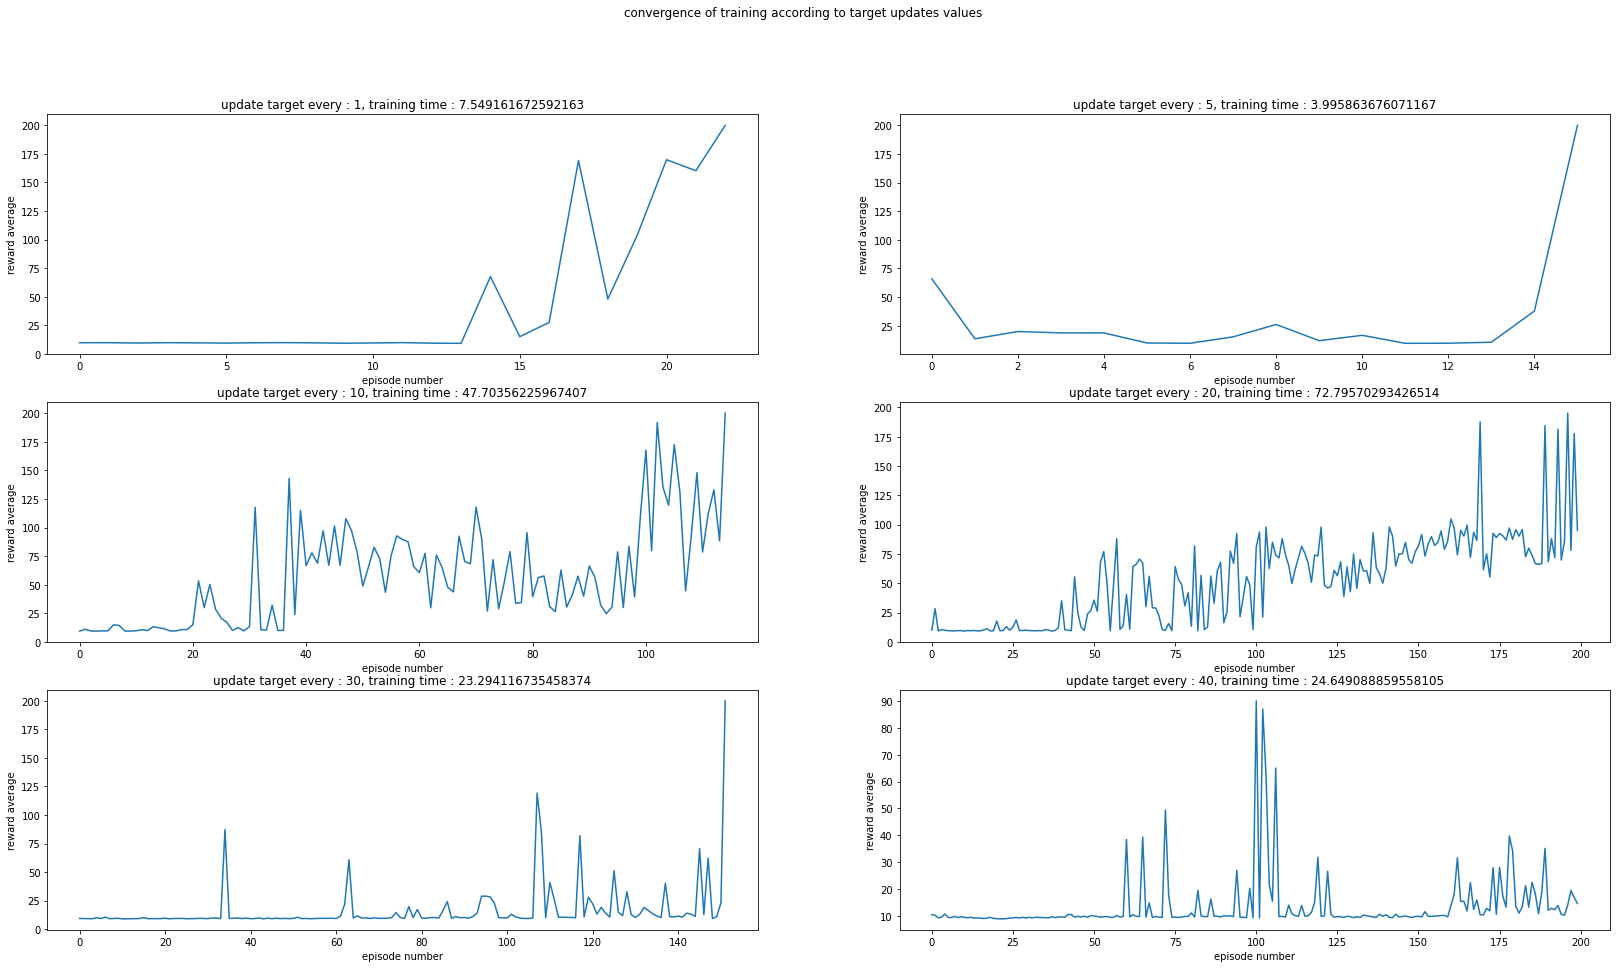

In [85]:
fig, axs = plt.subplots(3, 2, figsize=(28,15))
x=[[j for j in range(len(rewards_per_target_value[i])) ] for i in range(len(rewards_per_target_value))]
fig.suptitle('convergence of training according to target updates values')
axs[0, 0].plot(x[0], rewards_per_target_value[0])
axs[0, 0].set_title("update target every : "+str(target_every_values[0])+", training time : "+str(training_durations_target[0]))

axs[0, 1].plot(x[1], rewards_per_target_value[1])
axs[0, 1].set_title("update target every : "+str(target_every_values[1])+", training time : "+str(training_durations_target[1]))

axs[1, 0].plot(x[2], rewards_per_target_value[2])
axs[1, 0].set_title("update target every : "+str(target_every_values[2])+", training time : "+str(training_durations_target[2]))

axs[1, 1].plot(x[3], rewards_per_target_value[3])
axs[1, 1].set_title("update target every : "+str(target_every_values[3])+", training time : "+str(training_durations_target[3]))

axs[2, 0].plot(x[4], rewards_per_target_value[4])
axs[2, 0].set_title("update target every : "+str(target_every_values[4])+", training time : "+str(training_durations_target[4]))

axs[2, 1].plot(x[5], rewards_per_target_value[5])
axs[2, 1].set_title("update target every : "+str(target_every_values[5])+", training time : "+str(training_durations_target[5]))

for ax in axs.flat:
    ax.set(xlabel='episode number', ylabel='reward average')




**Graphs analysis target_net update**

*We can see that with a very frequent update of target_net : the reward values are unstable.*     
*On the contrary when the target_net is updated too rarely, the training fails to converge.*     
*It seems to be important to update the target_net paramerters (with the one of wq_net) every 10 to 20 episodes.*


#### Question 8

If you have the computer power to do so, try to do a grid search on those two hyper-parameters and comment the results. Otherwise, study the influence of another hyper-parameter.


In [86]:
BUFFER_CAPACITY = 16384
replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
UPDATE_TARGET_EVERY = 20

batch_values = [16, 32, 64, 128, 256, 512]
training_durations_batch = []
rewards_per_batch_value = []
for i in range(len(batch_values)):
    # create network and target network
    
    BATCH_SIZE = batch_values[i]
    q_net = Net(obs_size, hidden_size, n_actions)
    target_net = Net(obs_size, hidden_size, n_actions)

    # objective and optimizer
    objective = nn.MSELoss()
    optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)
    # Run the training loop
    start = time.time()
    rewards = get_train_info()
    end = time.time()

    training_durations_batch.append(end-start)
    rewards_per_batch_value.append(rewards)
    print("end of training with update_target_value : ", batch_values[i])


end of training with update_target_value :  16
end of training with update_target_value :  32
end of training with update_target_value :  64
end of training with update_target_value :  128
end of training with update_target_value :  256
end of training with update_target_value :  512


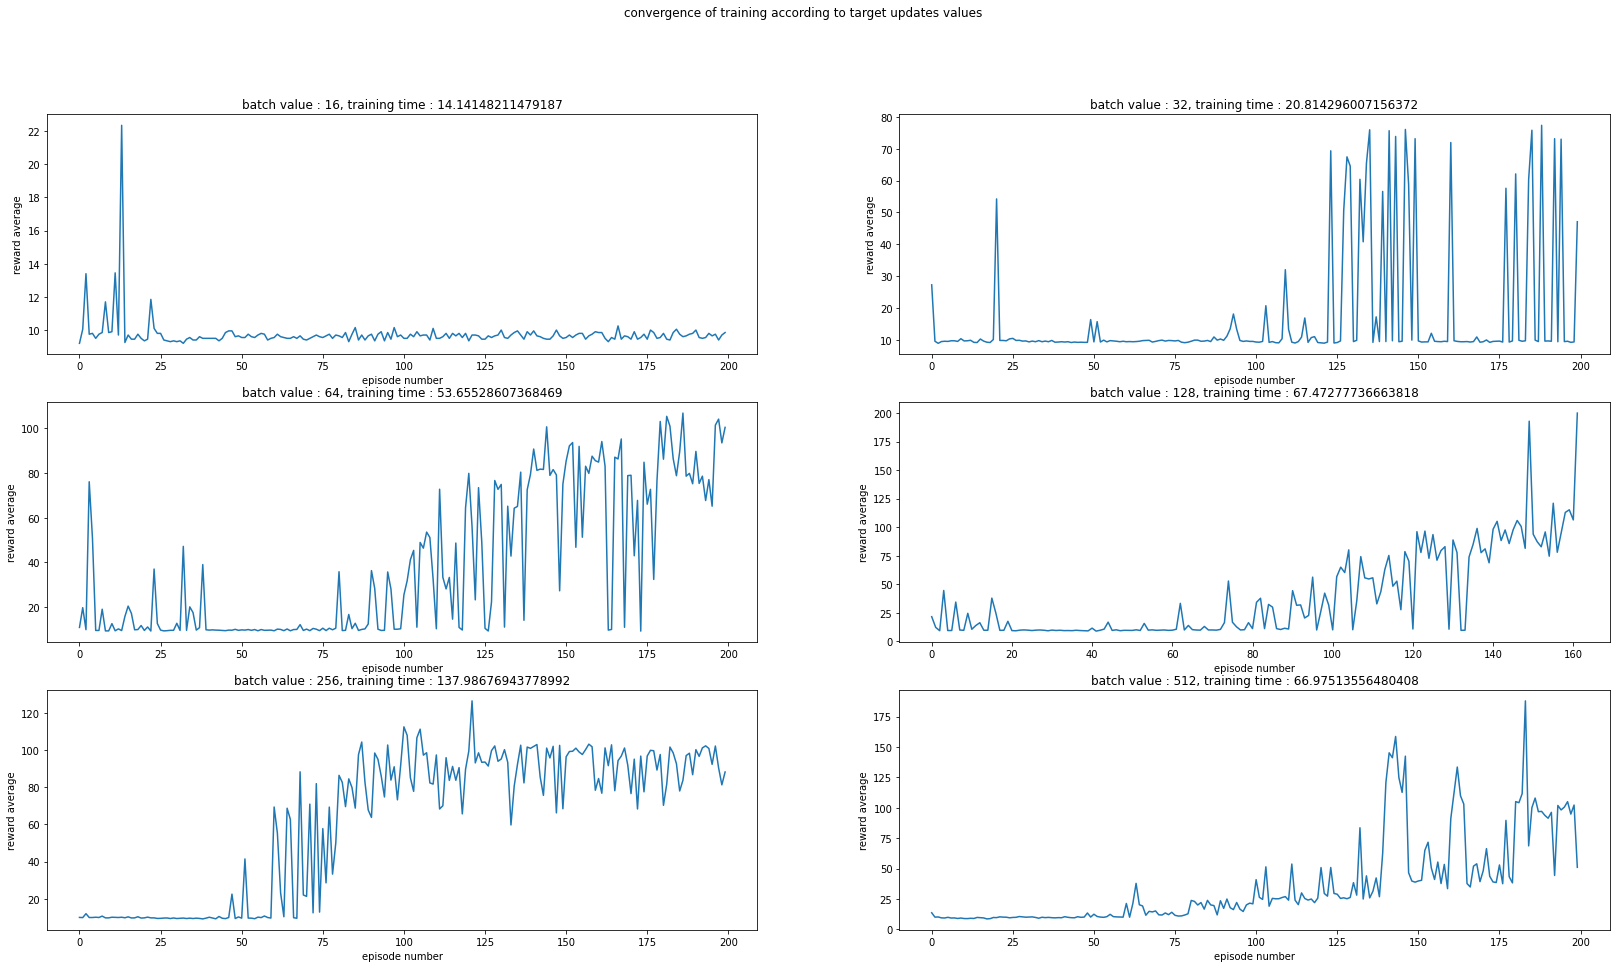

In [87]:
fig, axs = plt.subplots(3, 2, figsize=(28,15))
x=[[j for j in range(len(rewards_per_batch_value[i])) ] for i in range(len(rewards_per_batch_value))]
fig.suptitle('convergence of training according to target updates values')
axs[0, 0].plot(x[0], rewards_per_batch_value[0])
axs[0, 0].set_title("batch value : "+str(batch_values[0])+", training time : "+str(training_durations_batch[0]))

axs[0, 1].plot(x[1], rewards_per_batch_value[1])
axs[0, 1].set_title("batch value : "+str(batch_values[1])+", training time : "+str(training_durations_batch[1]))

axs[1, 0].plot(x[2], rewards_per_batch_value[2])
axs[1, 0].set_title("batch value : "+str(batch_values[2])+", training time : "+str(training_durations_batch[2]))

axs[1, 1].plot(x[3], rewards_per_batch_value[3])
axs[1, 1].set_title("batch value : "+str(batch_values[3])+", training time : "+str(training_durations_batch[3]))

axs[2, 0].plot(x[4], rewards_per_batch_value[4])
axs[2, 0].set_title("batch value : "+str(batch_values[4])+", training time : "+str(training_durations_batch[4]))

axs[2, 1].plot(x[5], rewards_per_batch_value[5])
axs[2, 1].set_title("batch value : "+str(batch_values[5])+", training time : "+str(training_durations_batch[5]))

for ax in axs.flat:
    ax.set(xlabel='episode number', ylabel='reward average')




**Graph analysis batch size**   
*The training time rises with the batch size. When the bitch size is too small, the training fails to converge.*

## Discretization

It is natural to use a function approximator like a neural network to approximate the $Q$ function in a continuous environment. Another natural but unscalable way to do handle continuous state-action space is **discretization**.

Discretize the environment of your choice (cartpole or mountain car or both) and run one of the algorithms that you know to compute an approximation of the optimal $Q$ function.

Once you are satisfied with your results, you may plot the *optimal phase diagram* of the system. For instance, you may get something like this for the mountain car environment.
![Phase diagram](./phase_plot.png)

*We would need to bucketize the states parameters.*